<a href="https://colab.research.google.com/github/francji1/01RAD/blob/main/code/01RAD_Ex09_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01RAD Exercise 09

* Robust Regression - How to deal with Outliers and Leverages
* Very fast intro of Robust regression - M, MM, LTS, LWS


In [198]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import seaborn as sns

import statsmodels.api as sm



In [199]:
# --- Robust LWS Implementation ---
def lws(y, X, weights, niter=100):
    """Least Weighted Squares (LWS) estimator with iterations."""
    import numpy as np
    import pandas as pd
    # 1. Ensure inputs are numpy arrays
    if hasattr(y, 'values'): y = y.values
    if hasattr(X, 'values'): X = X.values
    if hasattr(weights, 'values'): weights = weights.values
        
    y = np.asarray(y, dtype=float)
    X = np.asarray(X, dtype=float)
    weights = np.asarray(weights, dtype=float)
    if y.ndim > 1 and y.shape[1] == 1: y = y.flatten()
        
    n, p = X.shape
    w_profile = np.sort(weights)[::-1] 
    
    try: beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    except: beta = np.zeros(p)
        
    for _ in range(niter):
        residuals = y - X @ beta
        sq_res = residuals**2
        sorted_indices = np.argsort(sq_res)
        w_current = np.zeros(n)
        w_current[sorted_indices] = w_profile
        sqrt_w = np.sqrt(w_current)
        X_w = X * sqrt_w[:, np.newaxis]
        y_w = y * sqrt_w
        beta_new, _, _, _ = np.linalg.lstsq(X_w, y_w, rcond=None)
        if np.allclose(beta, beta_new, atol=1e-6):
            beta = beta_new
            break
        beta = beta_new
    return {'b': beta}

In [200]:
# --- Setup for Task Solutions ---
# This cell loads necessary data and defines helper functions used in the tasks below.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# Guarded Magic & Display for Script Portability
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass 
    
if 'display' not in globals():
    def display(obj):
        print(obj)

# Load Data (StarsCYG)
try:
    dta = sm.datasets.get_rdataset("starsCYG", "robustbase", cache=True).data
    y_stars = dta['log.light']
    X_stars = sm.add_constant(dta['log.Te'])
    x_grid = np.linspace(dta['log.Te'].min(), dta['log.Te'].max(), 200)
    X_grid = sm.add_constant(x_grid)
    print("StarsCYG data loaded successfully.")
except Exception as e:
    print(f"Warning: Could not load StarsCYG data: {e}")
    np.random.seed(42)
    dta = pd.DataFrame({'log.Te': np.random.normal(4, 0.5, 47), 'log.light': np.random.normal(5, 1, 47)})
    y_stars = dta['log.light']
    X_stars = sm.add_constant(dta['log.Te'])
    x_grid = np.linspace(dta['log.Te'].min(), dta['log.Te'].max(), 200)
    X_grid = sm.add_constant(x_grid)
    print("Fallback synthetic data generated.")

# Helper: Least Trimmed Squares
def least_trimmed_squares(x, y, alpha=0.9, max_iter=1000, tol=1e-6, n_starts=100):
    """Least Trimmed Squares via C-steps with multiple random starts."""
    y_arr = np.asarray(y).ravel()
    X = np.asarray(x)
    if X.ndim == 1: X = X.reshape(-1, 1)
    X_design = sm.add_constant(X)
    n, p1 = X_design.shape 
    h = int(np.ceil(alpha * n))
    if h <= p1: raise ValueError("alpha too small")
    best_obj = np.inf
    best_params = None
    rng = np.random.default_rng(42)

    for _ in range(n_starts):
        subset_idx = rng.choice(n, size=p1, replace=False)
        try: beta = np.linalg.lstsq(X_design[subset_idx], y_arr[subset_idx], rcond=None)[0]
        except: continue
        for _ in range(max_iter):
            residuals = y_arr - X_design @ beta
            order = np.argsort(residuals ** 2)
            keep = order[:h]
            X_h = X_design[keep]
            y_h = y_arr[keep]
            try: beta_new = np.linalg.lstsq(X_h, y_h, rcond=None)[0]
            except: break
            if np.linalg.norm(beta_new - beta) < tol:
                beta = beta_new
                break
            beta = beta_new
        residuals = y_arr - X_design @ beta
        order = np.argsort(residuals ** 2)
        keep = order[:h]
        obj = np.sum(residuals[keep] ** 2)
        if obj < best_obj:
            best_obj = obj
            best_params = beta
    if best_params is None: best_params = sm.OLS(y_arr, X_design).fit().params
    return best_params, None

StarsCYG data loaded successfully.


# Task Solutions

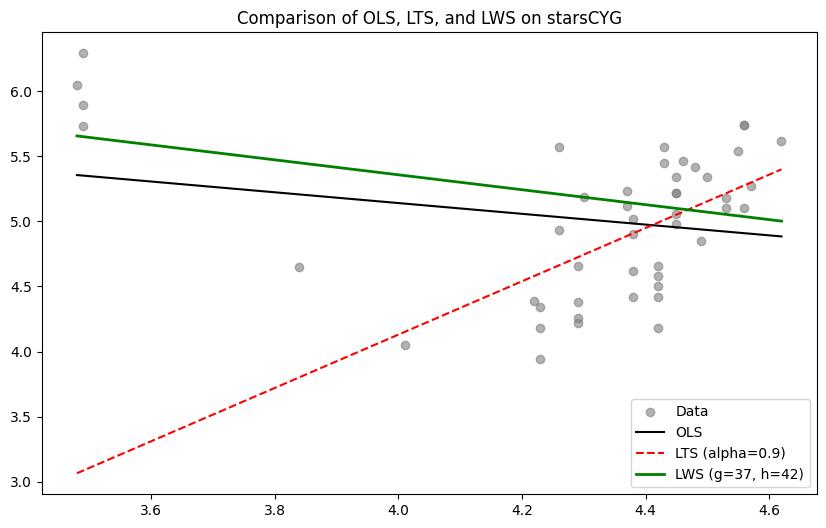

--- LWS Parameter Sensitivity (Grid Search) ---
    g   h  Intercept     Slope  MAD_Resid
4  32  42   8.071547 -0.661693   0.399552
6  37  39   7.780661 -0.595949   0.399605
5  32  44   8.042007 -0.662788   0.399651
2  28  44   8.167147 -0.685365   0.401683
1  28  42   8.279169 -0.707077   0.407071
0  28  39   8.357247 -0.715863   0.407159
3  32  39   8.338477 -0.716909   0.407169
7  37  42   7.651863 -0.573647   0.419454
8  37  44   7.595957 -0.565731   0.426499


In [201]:
# Task 1 & 2: LWS Implementation and Comparison

def Weights2(n, g, h):
    '''Generate weights for LWS.'''
    w = np.zeros(n)
    if g > 0: w[:g] = np.linspace(1, 0.9, g)
    if h > g: w[g:h] = np.linspace(0.9, 0, h - g)
    return w

n_stars = len(y_stars)
g_param = int(0.8 * n_stars)
h_param = int(0.9 * n_stars)
w_stars = Weights2(n_stars, g_param, h_param)

lws_fit = lws(y_stars, X_stars, w_stars, niter=100)
lws_params = lws_fit['b']
ols_re = sm.OLS(y_stars, X_stars).fit()
lts_p, _ = least_trimmed_squares(dta['log.Te'], dta['log.light'], alpha=0.9, max_iter=20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(dta['log.Te'], dta['log.light'], color='gray', alpha=0.6, label='Data')
ax.plot(x_grid, ols_re.predict(X_grid), color='black', label='OLS')
ax.plot(x_grid, X_grid @ lts_p, color='red', linestyle='--', label='LTS (alpha=0.9)')
ax.plot(x_grid, X_grid @ lws_params, color='green', linewidth=2, label=f'LWS (g={g_param}, h={h_param})')
ax.set_title('Comparison of OLS, LTS, and LWS on starsCYG')
ax.legend()
plt.show()

# Parameter Sensitivity (Grid Search over g, h)
print("--- LWS Parameter Sensitivity (Grid Search) ---")
results_grid = []
g_range = [int(p * n_stars) for p in [0.6, 0.7, 0.8]]
h_range = [int(p * n_stars) for p in [0.85, 0.9, 0.95]]

for g_try in g_range:
    for h_try in h_range:
        if h_try <= g_try: continue
        w_try = Weights2(n_stars, g_try, h_try)
        res = lws(y_stars, X_stars, w_try, niter=20)
        resid = y_stars - X_stars @ res['b']
        mad_res = stats.median_abs_deviation(resid)
        results_grid.append({'g': g_try, 'h': h_try, 'Intercept': res['b'][0], 'Slope': res['b'][1], 'MAD_Resid': mad_res})

display(pd.DataFrame(results_grid).sort_values('MAD_Resid'))

Running simulation: 0.0% Outliers...
Running simulation: 5.0% Outliers...
Running simulation: 10.0% Outliers...


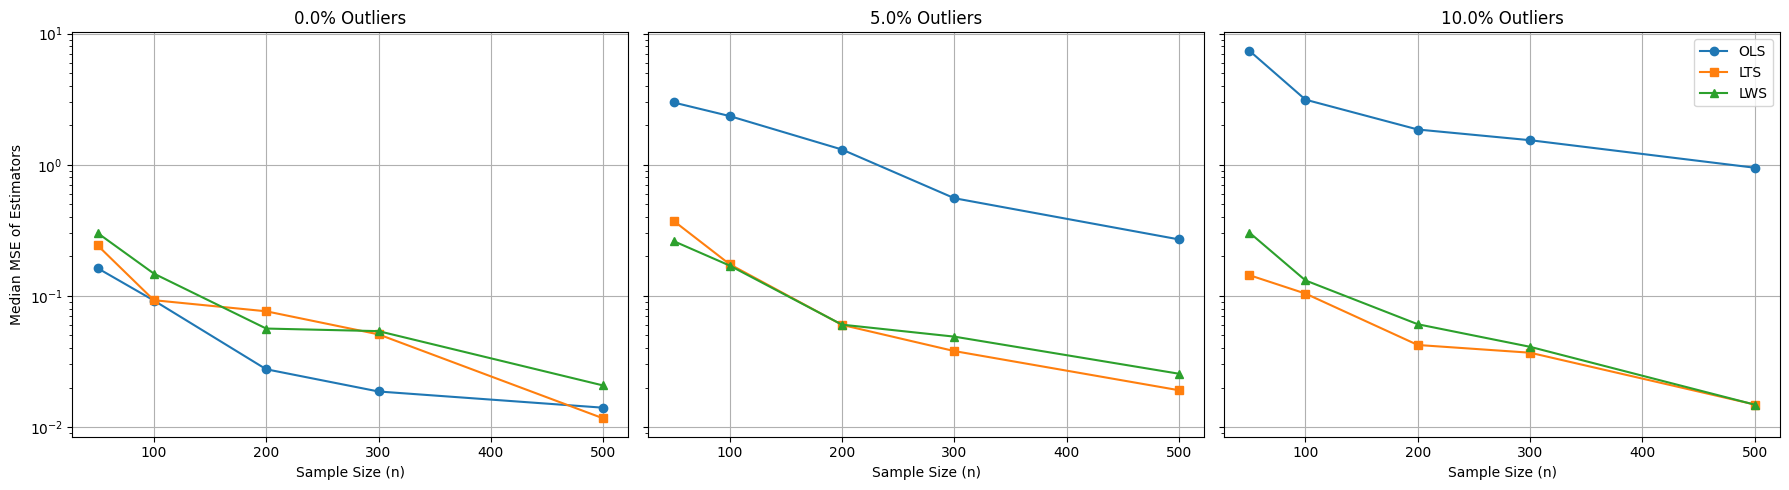

--- Summary Results Table (Median MSE) ---
Method             LTS       LWS       OLS
Outliers N                                
0.00     50   0.242190  0.300924  0.162409
         100  0.092699  0.147863  0.092210
         200  0.076302  0.056364  0.027583
         300  0.050891  0.053866  0.018673
         500  0.011654  0.020751  0.014047
0.05     50   0.373513  0.261735  2.982214
         100  0.174279  0.170194  2.348892
         200  0.060105  0.060342  1.305314
         300  0.037957  0.048904  0.555521
         500  0.019088  0.025502  0.269524
0.10     50   0.143912  0.304022  7.397550
         100  0.104120  0.131148  3.132382
         200  0.042233  0.060781  1.854933
         300  0.036878  0.040895  1.537688
         500  0.014854  0.014818  0.948391


In [202]:
# Task 3, 4, 5: Comprehensive Simulation (Consistency & Outlier Handling)

ns = [50, 100, 200, 300, 500] 
n_reps = 100 
outlier_settings = [0.0, 0.05, 0.10]
beta0 = np.array([2, 3, -2, 2, 3])
all_results = []

for out_pct in outlier_settings:
    print(f"Running simulation: {out_pct*100}% Outliers...")
    for n in ns:
        mse_ols, mse_lts, mse_lws = [], [], []
        n_out = int(n * out_pct)
        g_lws, h_lws = int(0.8 * n), int(0.9 * n)
        w_lws = Weights2(n, g_lws, h_lws)
        
        for _ in range(n_reps):
            X = np.column_stack([np.ones(n), np.random.binomial(10, 0.3, n)+1, np.random.normal(10, 2, n), np.random.normal(20, 3, n), np.random.exponential(8, n)])
            y = X @ beta0 + np.random.normal(0, 1, n)
            if n_out > 0: y[np.random.choice(n, n_out, replace=False)] += 20
            
            try: b = np.linalg.lstsq(X, y, rcond=None)[0]; mse_ols.append(np.mean((b - beta0)**2))
            except: pass
            try: b, _ = least_trimmed_squares(X[:, 1:], y, alpha=0.9, max_iter=5, n_starts=1); mse_lts.append(np.mean((b - beta0)**2))
            except: pass
            try: lws_res = lws(y, X, w_lws, niter=5); mse_lws.append(np.mean((lws_res['b'] - beta0)**2))
            except: pass
            
        if mse_ols: all_results.append({'Outliers': out_pct, 'N': n, 'Method': 'OLS', 'Median_MSE': np.median(mse_ols)})
        if mse_lts: all_results.append({'Outliers': out_pct, 'N': n, 'Method': 'LTS', 'Median_MSE': np.median(mse_lts)})
        if mse_lws: all_results.append({'Outliers': out_pct, 'N': n, 'Method': 'LWS', 'Median_MSE': np.median(mse_lws)})

df_results = pd.DataFrame(all_results)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
methods = ['OLS', 'LTS', 'LWS']
markers = {'OLS': 'o', 'LTS': 's', 'LWS': '^'}
for i, pct in enumerate(outlier_settings):
    ax = axes[i]
    subset = df_results[df_results['Outliers'] == pct]
    if subset.empty: continue
    for method in methods:
        data = subset[subset['Method'] == method]
        ax.plot(data['N'], data['Median_MSE'], marker=markers[method], label=method)
    ax.set_title(f'{pct*100}% Outliers'); ax.set_xlabel('Sample Size (n)'); ax.set_yscale('log'); ax.grid(True)
    if i == 0: ax.set_ylabel('Median MSE of Estimators')
    if i == 2: ax.legend()
plt.tight_layout(); plt.show()

print("--- Summary Results Table (Median MSE) ---")
try:
    pivot_res = df_results.pivot_table(index=['Outliers', 'N'], columns='Method', values='Median_MSE')
    display(pivot_res)
except:
    print(df_results)